In [1]:
import os, sys, math, gc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from utils.utils import merge_eval_sold_on_df, sort_df_on_d, WRMSSE, RMSSE, _down_cast, data_preprocessing, diff_lists, log_status #create_submission_df
from utils.utils import customIter

from utils.configure_logger import configure_logger
configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [3]:
DATA_BASE_PATH = '../data/m5-forecasting-accuracy/'
SALES_EVALUATION = 'sales_train_evaluation.csv'
SALES_VALIDATION = 'sales_train_validation.csv'
CALENDAR = 'calendar.csv'
SAMPLE_SUBMISSION = 'sample_submission.csv'
SELL_PRICES = 'sell_prices.csv'

PRECOMPUTED_BASE_PATH = '../data/uncertainty/features/'

DAYS: int = 28

In [4]:
# read all data
sales_validation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_VALIDATION))
sales_evaluation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_EVALUATION))
calendar: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + CALENDAR))
sample_submission: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SAMPLE_SUBMISSION))
sell_prices: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SELL_PRICES))

### Feature Engineering and Cross Validation

#### Test Runs

In [6]:
# ~25 seconds
df, submission_idx = data_preprocessing(sales_evaluation.iloc[:int(20)], calendar, sell_prices)
df = df[(df.wm_yr_wk > df.release)]
df['id'] = df['id'].astype(str)

In [7]:
df.groupby('id')['sold'].ngroups#.rolling(3).mean()

20

In [8]:

@log_status
def compute_features(df: pd.DataFrame):
    feature_columns = []
    feature_columns += ['sell_price'] + ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'sold']
    
    # precomputing
    df["index"] = df.index
    df["d_int"] = df["d"].apply(lambda x: int(x.split("_")[-1]))
    df["day"] = str(df.date.dt.day)
    
    ################################################
    ############### AUTOCORRELATION ################
    ################################################
    PREFIX = 'auto_'
    logger.info('Computing autocorrelation features')
    # DIRECT LAGGED VALUES
    old_columns: set = set(df.columns)
    LAG_SHIFT: int = 28
    for lag in [1, 2, 7, 14, 21]:
        df[PREFIX + f"sold_{lag}"] = df.groupby("id")["sold"].shift(lag+LAG_SHIFT) # 1-day lag
    feature_columns += list(set(df.columns) - old_columns)
    
    # MOVING AVERAGES
    old_columns: set = set(df.columns)
    for i in [7, 14, 21, 28, 60, 180]:
        df[PREFIX + f'sold_ma_{i}'] = df.groupby(['id'])['sold'].transform(lambda x: x.shift(LAG_SHIFT).rolling(i).mean()).astype(np.float16)
        df[PREFIX + f'sold_ma_std_{i}'] = df.groupby(['id'])['sold'].transform(lambda x: x.shift(LAG_SHIFT).rolling(i).std()).astype(np.float16)
    feature_columns += list(set(df.columns) - old_columns)
    
    # # EXPONENTIAL SMOOTHING AVERAGES
    # old_columns: set = set(df.columns)
    # df['sold_ewm_0.05'] = df.groupby('id')['sold'].transform(lambda x: x.ewm(alpha=0.05).mean().shift(1))
    # df['sold_ewm_0.1'] = df.groupby('id')['sold'].transform(lambda x: x.ewm(alpha=0.1).mean().shift(1))
    # df['sold_ewm_0.2'] = df.groupby('id')['sold'].transform(lambda x: x.ewm(alpha=0.2).mean().shift(1))
    # df['sold_ewm_0.01'] = df.groupby('id')['sold'].transform(lambda x: x.ewm(alpha=0.01).mean().shift(1))
    # feature_columns += list(set(df.columns) - old_columns)
    
    # # DIFFERENCES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    ###############################################
    ############ PRICE AUTOCORRELATION ############
    ###############################################
    logger.info('Computing price autocorrelation features')
    # # DIRECT LAGGED VALUES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    # # MOVING AVERAGES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    # # EXPONENTIAL SMOOTHING AVERAGES
    # old_columns = set(df.columns)
    # feature_columns += list(set(df.columns) - old_columns)
    
    # PRICE DIFFERENCES
    PREFIX = 'momentum_'
    old_columns = set(df.columns)
    df[PREFIX + 'sell_price_w'] = df['sell_price'] / df.groupby(['id', 'wm_yr_wk'])['sell_price'].transform(lambda x: x.shift(1))
    df[PREFIX + 'sell_price_m'] = df['sell_price'] / df.groupby(['id', 'year', 'month'])['sell_price'].transform(lambda x: x.shift(1))
    df[PREFIX + 'sell_price_y'] = df['sell_price'] / df.groupby(['id', 'year'])['sell_price'].transform(lambda x: x.shift(1))
    feature_columns += list(set(df.columns) - old_columns)

    ################################################
    ############ PRODUCT CHARACTERISTICS ###########
    ################################################
    logger.info('Computing unconditional sold values')
    # UNCONDITIONAL SALES
    PREFIX = 'unconditional_'
    # old_columns = set(df.columns)
    # df['sold_mean'] = df.groupby(['id'])['sold'].transform(lambda x: x.mean())
    # df['sold_std'] = df.groupby(['id'])['sold'].transform(lambda x: x.std())
    # df['sold_max'] = df.groupby(['id'])['sold'].transform(lambda x: x.max())
    # feature_columns += list(set(df.columns) - old_columns)
    old_columns = set(df.columns)    
    icols =  [
        ['state_id'],
        ['store_id'],
        ['cat_id'],
        ['dept_id'],
        ['state_id', 'cat_id'],
        ['state_id', 'dept_id'],
        ['store_id', 'cat_id'],
        ['store_id', 'dept_id'],
        ['item_id'],
        ['item_id', 'state_id'],
        ['item_id', 'store_id']
    ]
    for col in icols:
        col_name = '_'+'_'.join(col)+'_'
        df[PREFIX + 'sold'+col_name+'median'] = df.groupby(col)['sold'].transform('median').astype(np.float16)
        df[PREFIX + 'sold'+col_name+'mean'] = df.groupby(col)['sold'].transform('mean').astype(np.float16)
        df[PREFIX + 'sold'+col_name+'std'] = df.groupby(col)['sold'].transform('std').astype(np.float16)
    feature_columns += list(set(df.columns) - old_columns)

    ################################################
    ############## SEASONAL FEATURES ###############
    ################################################
    logger.info('Encoding date features to dummies')
    PREFIX = 'seasonal_'
    # WEEK / MONTH DUMMIES
    encode_columns = ['weekday', 'month']
    old_columns = set(df.columns)
    df = pd.get_dummies(df, columns = encode_columns, prefix=PREFIX, prefix_sep='')
    feature_columns += list(set(df.columns) - old_columns)
    
    # for day, no dummy encoding
    df['seasonal_d_int'] = df['d_int']
    feature_columns += ['seasonal_d_int']
    
    # return final results
    df = _down_cast(df)
    return df[feature_columns]

In [9]:
# total ~77 seconds
features = compute_features(df.copy())
print(features.shape)

2023-08-10 18:18:03 - compute_features - INFO - calling
2023-08-10 18:18:03 - __main__ - INFO - Computing autocorrelation features
2023-08-10 18:18:04 - __main__ - INFO - Computing price autocorrelation features
2023-08-10 18:18:04 - __main__ - INFO - Computing unconditional sold values
2023-08-10 18:18:04 - __main__ - INFO - Encoding date features to dummies


(33675, 70)


<Axes: >

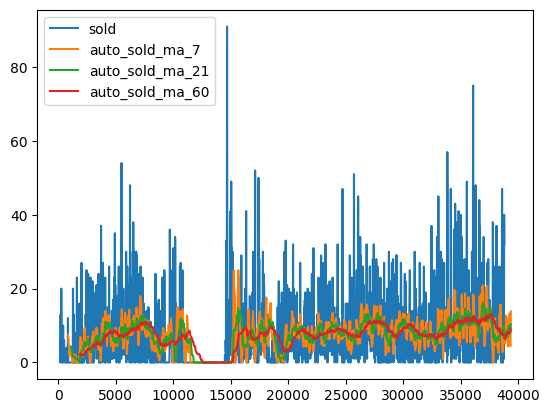

In [10]:
features[features['id'] == 'HOBBIES_1_008_CA_1_evaluation'][['sold', 'auto_sold_ma_7', 'auto_sold_ma_21', 'auto_sold_ma_60']].plot()

In [11]:
features.columns

Index(['sell_price', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd',
       'sold', 'auto_sold_21', 'auto_sold_1', 'auto_sold_14', 'auto_sold_7',
       'auto_sold_2', 'auto_sold_ma_60', 'auto_sold_ma_std_60',
       'auto_sold_ma_28', 'auto_sold_ma_180', 'auto_sold_ma_std_28',
       'auto_sold_ma_14', 'auto_sold_ma_std_21', 'auto_sold_ma_21',
       'auto_sold_ma_std_180', 'auto_sold_ma_7', 'auto_sold_ma_std_14',
       'auto_sold_ma_std_7', 'momentum_sell_price_m', 'momentum_sell_price_y',
       'momentum_sell_price_w', 'unconditional_sold_store_id_dept_id_mean',
       'unconditional_sold_state_id_dept_id_std',
       'unconditional_sold_state_id_cat_id_std',
       'unconditional_sold_cat_id_std',
       'unconditional_sold_state_id_dept_id_mean',
       'unconditional_sold_item_id_state_id_mean',
       'unconditional_sold_item_id_store_id_std',
       'unconditional_sold_store_id_std', 'unconditional_sold_state_id_mean',
       'unconditional_sold_item_id_std', 'uncondit

###

### Final Runs for Validation and Evaluation

In [12]:

# pivot initial dataframe and compute features/targets
df_val, submission_idx_validation = data_preprocessing(sales_validation, calendar, sell_prices)
df_val_after_release = df_val[(df_val.wm_yr_wk > df_val.release)]
del df_val

In [13]:
features = compute_features(df_val_after_release)
for c in features.columns:
    if c not in ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd']:
        features[c] = features[c].astype(np.float32)
features.to_parquet(PRECOMPUTED_BASE_PATH + 'features_val.parquet', index=False)
del df_val_after_release
del features

2023-08-10 18:18:45 - compute_features - INFO - calling
2023-08-10 18:18:59 - __main__ - INFO - Computing autocorrelation features
2023-08-10 18:21:27 - __main__ - INFO - Computing price autocorrelation features
2023-08-10 18:37:09 - __main__ - INFO - Computing unconditional sold values
2023-08-10 18:37:27 - __main__ - INFO - Encoding date features to dummies


In [14]:
# pivot initial dataframe and compute features/targets
df_eval, submission_idx_validation = data_preprocessing(sales_evaluation, calendar, sell_prices)
df_eval_after_release = df_eval[(df_eval.wm_yr_wk > df_eval.release)]
del df_eval

In [15]:
features = compute_features(df_eval_after_release)
for c in features.columns:
    if c not in ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd']:
        features[c] = features[c].astype(np.float32)
features.to_parquet(PRECOMPUTED_BASE_PATH + 'features_eval.parquet', index=False)
del df_eval_after_release
del features

2023-08-10 18:39:47 - compute_features - INFO - calling
2023-08-10 18:40:00 - __main__ - INFO - Computing autocorrelation features
2023-08-10 18:42:19 - __main__ - INFO - Computing price autocorrelation features
2023-08-10 18:58:33 - __main__ - INFO - Computing unconditional sold values
2023-08-10 18:58:52 - __main__ - INFO - Encoding date features to dummies
